# Baynes Sound upwelling runs setup

***

In [153]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from datetime import datetime, timedelta
from cmocean import cm
from salishsea_tools import places, grid_tools, utilities, viz_tools

%matplotlib inline

***

### Define paths, get grid and mask files, and build HRDPS mask

In [4]:
# Results paths
path_HRDPS = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1'
path_NEMO = '/results/SalishSea/hindcast.201812'

# Load grid and mask files
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy_NEMO = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')
mask_NEMO = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Build HRDPS mask
mask_HRDPS = grid_tools.build_GEM_mask(grid_HRDPS, bathy_NEMO, mask_NEMO.tmask[0, 0, ...])

Building GEM mask 100% (68096 of 68096) |###################################|Time: 0:07:10


***

## 2015 Apr 24 - 29 upwelling case

In [75]:
# Specify daterange
daterange = [datetime(2015, 4, 24), datetime(2015, 4, 29)]
hours = [60, 72, 84, 96]
sections = [650, 600, 550, 500]

***

### HRDPS record at Sentry Shoal

In [37]:
# Retrieve HRDPS record at Sentry Shoal
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
data = xr.open_dataset(path_HRDPS).sel(time=slice(*daterange)).isel(gridY=j, gridX=i)
SentryShoal = {
    'time': np.array(data.time.values.astype('datetime64[s]').astype(datetime)),
    'magnitude': np.sqrt(data.u_wind**2 + data.v_wind**2),
    'angle': np.degrees(np.arctan(data.v_wind / data.u_wind)),
}

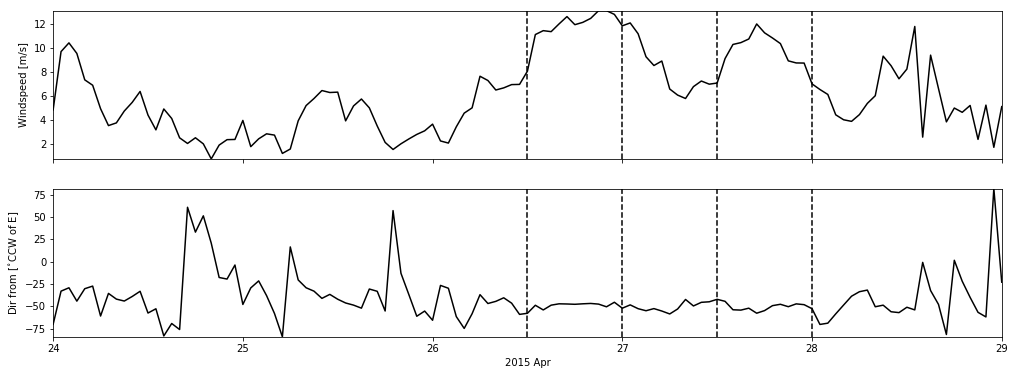

In [38]:
# Plot HRDPS record at Sentry Shoal
fig, axs = plt.subplots(2, 1, figsize=(17, 6))
axs[0].xaxis.set_ticklabels('')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
axs[1].set_xlabel(daterange[0].strftime('%Y %b'))
for ax, key, label in zip(axs, ['magnitude', 'angle'], ['Windspeed [m/s]', 'Dir from [$^{\circ}$CCW of E]']):
    ylim = [SentryShoal[key].min(), SentryShoal[key].max()]
    ax.plot(SentryShoal['time'], SentryShoal[key], 'k-')
    for hour in hours:
        date = daterange[0] + timedelta(hours=hour)
        ax.plot([date, date], ylim, 'k--')
    ax.set_xlim(daterange)
    ax.set_ylim(ylim)
    ax.set_ylabel(label)

***

### HRDPS snapshots over northern Strait

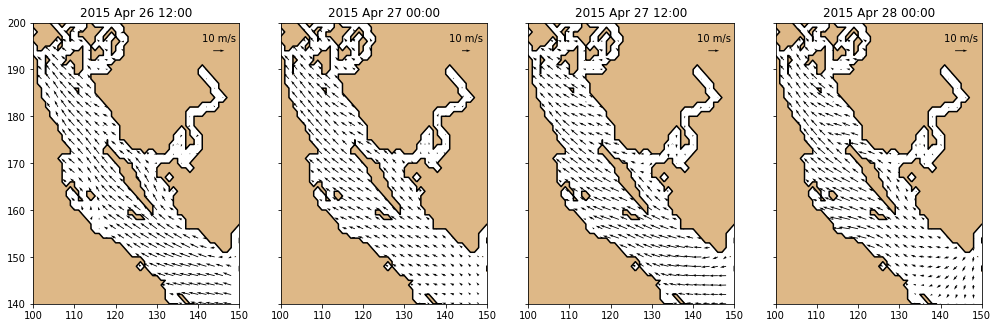

In [33]:
# Plot HRDPS snapshots over northern Strait
xrange = [100, 150]
yrange = [140, 200]
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, hour in zip(axs, hours):
    date = daterange[0] + timedelta(hours=hour)
    data = xr.open_dataset(path_HRDPS).sel(time=date).isel(gridY=slice(*yrange), gridX=slice(*xrange))
    q = ax.quiver(np.arange(*xrange, 2), np.arange(*yrange, 2), data.u_wind[::2, ::2], data.v_wind[::2, ::2], width=0.004)
    ax.contourf(mask_HRDPS, levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(mask_HRDPS, levels=[-0.01, 0.01], colors='k')
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_title(data.time.values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    ax.quiverkey(q, 0.9, 0.9, 10, '10 m/s')
    viz_tools.set_aspect(ax)
    if hour > 60:
        ax.yaxis.set_ticklabels('')

***

### Hindcast tracer over northern Strait

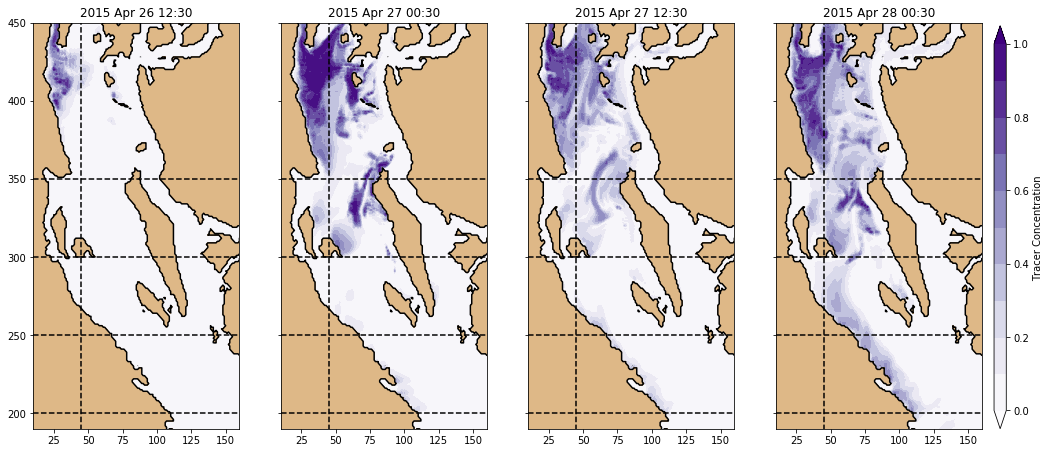

In [242]:
# Plot hindcast snapshots over northern Strait
xrange = [100, 398]
yrange = [300, 898]
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
for ax, hour in zip(axs, hours):
    date = daterange[0] + timedelta(hours=hour)
    datestr = date.strftime('%Y%m%d')
    fn = os.path.join(path_NEMO, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_mtrc_T.nc')
    data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')
    c = ax.contourf(data.x, data.y, data.tracer20m[0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'), extend='both')
    ax.contourf(mask_NEMO.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(mask_NEMO.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    ax.plot([45, 45], [0, 898], 'k--')
    for y in sections:
        ax.plot([10, 160], [y - yrange[0], y - yrange[0]], 'k--')
    ax.set_xlim([10, 160])
    ax.set_ylim([190, 450])
    ax.set_title(data.time_counter.values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    viz_tools.set_aspect(ax)
    if hour > 60:
        ax.yaxis.set_ticklabels('')
fig.colorbar(c, cax=cax, label='Tracer Concentration')
plt.show()

***

### Hindcast T and S sections

In [172]:
def plot_sections(key, levels, cmap, label):
    """
    """
    
    fig, axs = plt.subplots(4, 4, figsize=(17, 12))
    cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    xlims = [(115, 205), (115, 240), (165, 243), (205, 295)]
    for col, hour in zip(axs.T, hours):
        date = daterange[0] + timedelta(hours=hour)
        datestr = date.strftime('%Y%m%d')
        fn = os.path.join(path_NEMO, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_grid_T.nc')
        data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')
        for ax, y, xlim in zip(col, sections, xlims):
            S = np.ma.masked_where(mask_NEMO.tmask[0, :, y, :] == 0, data[key][:, y, :])
            c = ax.contourf(data.x, data.deptht, S, levels=np.arange(*levels), cmap=cmap, extend='both')
            ax.contourf(data.x, data.deptht, mask_NEMO.tmask[0, :, y, :], levels=[-0.01, 0.01], colors='Burlywood')
            ax.contour(data.x, data.deptht, mask_NEMO.tmask[0, :, y, :], levels=[-0.01, 0.01], colors='k')
            ax.set_xlim(xlim)
            ax.set_ylim([60, 0])
            if y == 650:
                ax.set_title(data.time_counter.values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
            if (y == 550) and (hour == hours[0]):
                ax.plot([230, 230], [0, 60], 'w--')
            if hour > 60:
                ax.yaxis.set_ticklabels('')
    fig.colorbar(c, cax=cax, label=label)
    plt.show()
    
    return fig, ax

**Salinity**

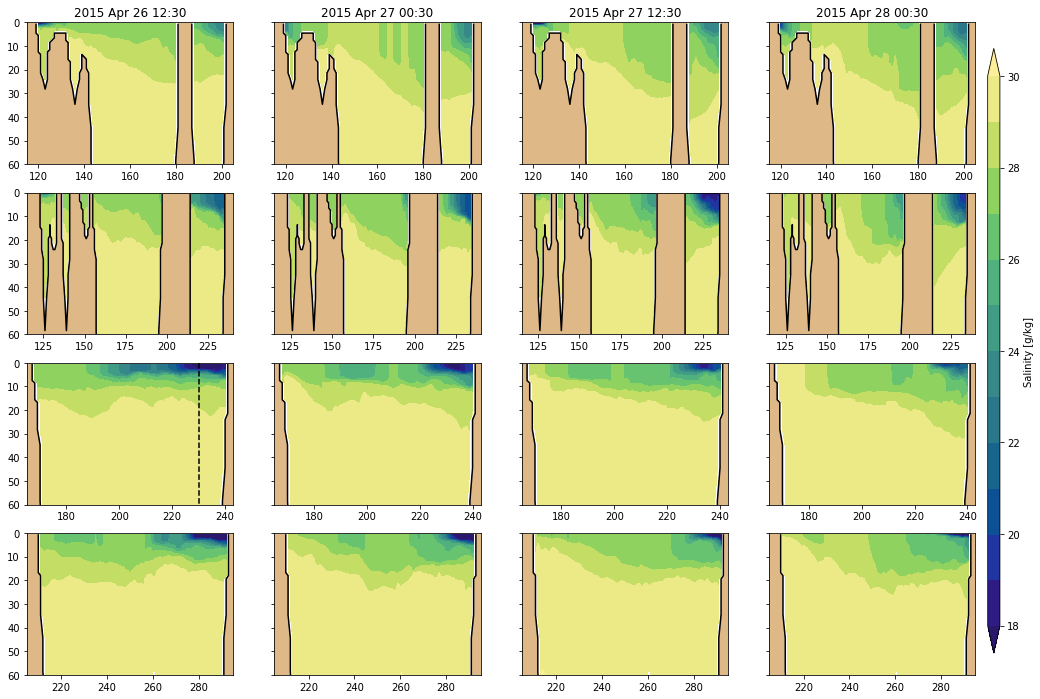

In [171]:
fig, ax = plot_sections('vosaline', [18, 31, 1], cm.haline, 'Salinity [g/kg]')

**Temperature**

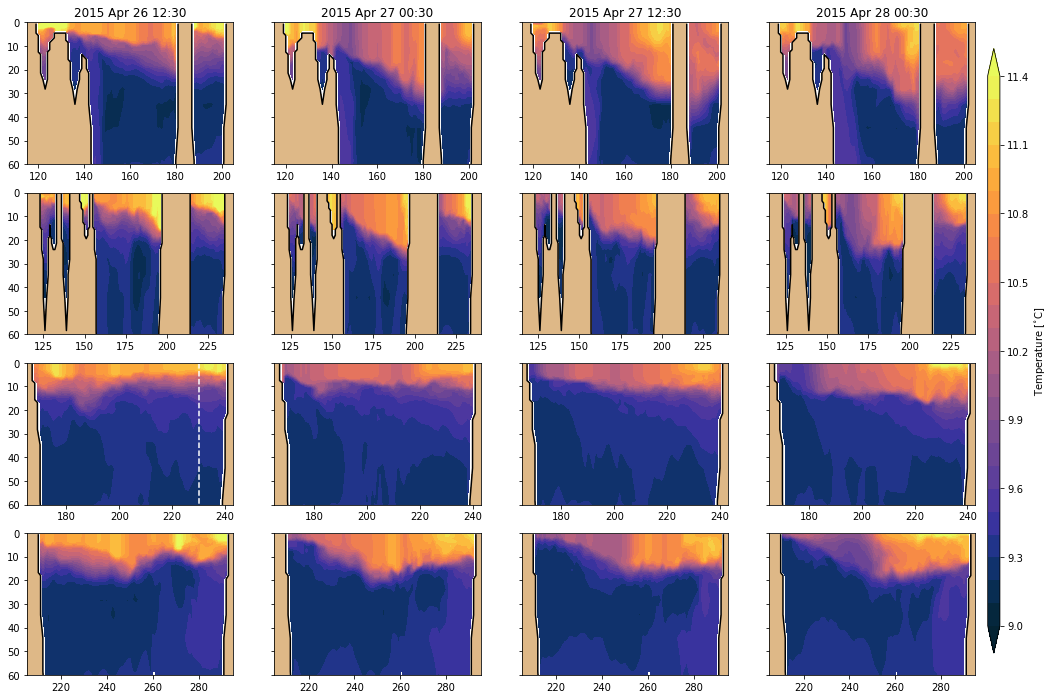

In [173]:
fig, ax = plot_sections('votemper', [9, 11.5, 0.1], cm.thermal, 'Temperature [$^{\circ}$C]')

***

### Initialization profiles

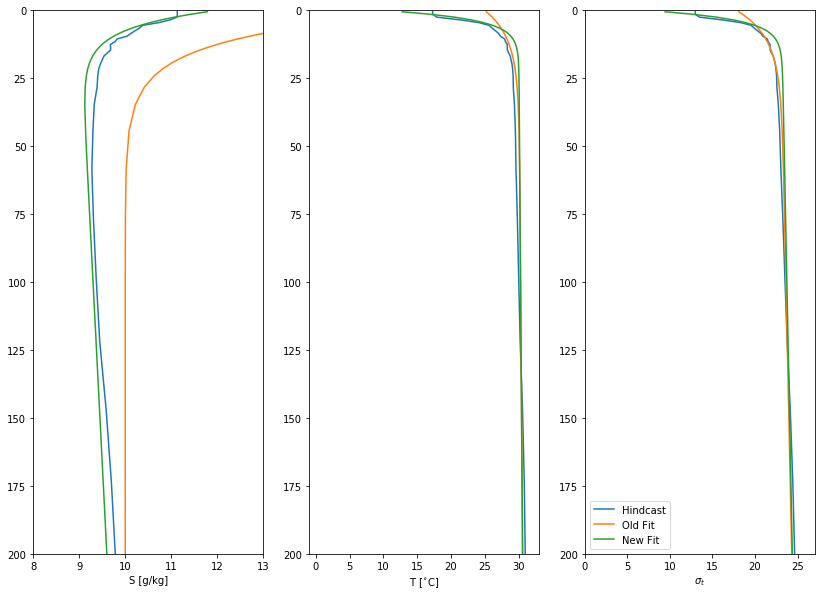

In [176]:
# Extract profiles from hindcast
date = daterange[0] + timedelta(hours=hours[0])
datestr = date.strftime('%Y%m%d')
fn = os.path.join(path_NEMO, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_grid_T.nc')
data = xr.open_dataset(fn).isel(y=550, x=230).sel(time_counter=date, method='nearest')

# Initialization profiles in SalishSeaIdeal
T_old = 7 * np.exp(-0.1 * data.deptht) + 10
S_old = -5 * np.exp(-0.1 * data.deptht) + 0.003 * data.deptht + 30
T_new = 3 * np.exp(-0.15 * data.deptht) + 0.003 * data.deptht + 9
S_new = -20 * np.exp(-0.3 * data.deptht) + 0.003 * data.deptht + 30

# Make figure
fig, axs = plt.subplots(1, 3, figsize=(14, 10))
qtys = [[data.votemper, T_old, T_new], [data.vosaline, S_old, S_new]]

# Plot T and S
for ax, qty, xlim, xlabel in zip(axs, qtys, [[8, 13], [-1, 33]], ['S [g/kg]', 'T [$^{\circ}$C]']):
    for x, label in zip(qty, ['Hindcast', 'Old Fit', 'New Fit']):
        ax.plot(x, data.deptht, label=label)
    ax.set_xlim(xlim)
    ax.set_ylim([200, 0])
    ax.set_xlabel(xlabel)

# Plot sigma
for s, t, label in zip(qtys[1], qtys[0], ['Hindcast', 'Old Fit', 'New Fit']):
    axs[2].plot(gsw.rho(s, t, data.deptht) - 1e3, data.deptht, label=label)
    axs[2].set_xlim([0, 27])
    axs[2].set_ylim([200, 0])
    axs[2].set_xlabel('$\sigma_t$')
    axs[2].legend(loc=3)

***

### New max stratification run
   * Analytical winds
   * Spatially homogeneous stratification

Still too much upwelling to the south of Baynes Sound compared to the hindcast.

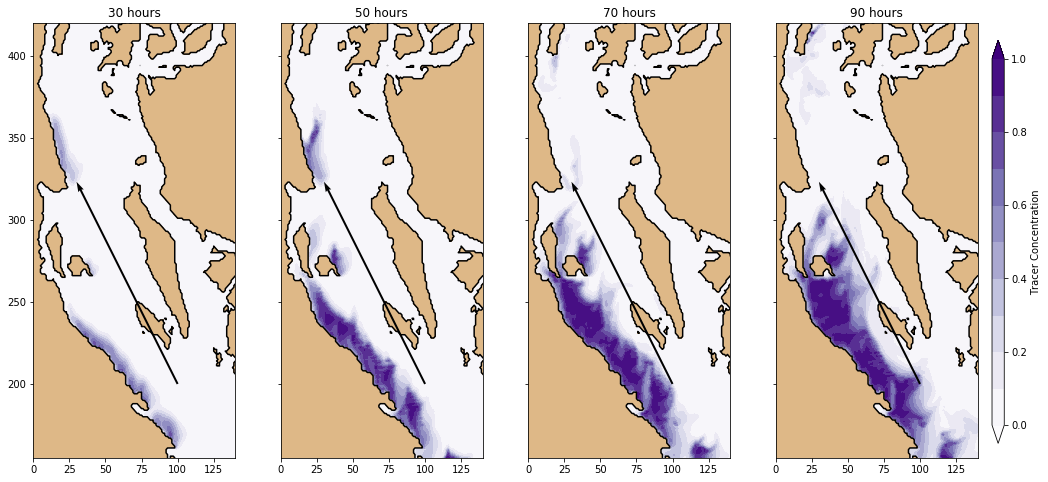

In [188]:
# Plot hindcast snapshots over northern Strait
xrange = [114, 398]
yrange = [334, 898]
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
data = xr.open_dataset('/data/bmoorema/results/pond/lake/SalishSeaPond_lake_SE4d_newstrat/SalishSeaIdeal_1h_20170701_20170706_grid_T.nc')
for ax, hour in zip(axs, [30, 50, 70, 90]):
    c = ax.contourf(data.x, data.y, data.tracer20m[hour, 0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'), extend='both')
    ax.contourf(mask_NEMO.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(mask_NEMO.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    ax.quiver(100, 200, -0.5, 1, width=0.01, scale=1)
    ax.set_xlim([0, 140])
    ax.set_ylim([155, 420])
    ax.set_title(f'{hour} hours')
    viz_tools.set_aspect(ax)
    if hour > 40:
        ax.yaxis.set_ticklabels('')
fig.colorbar(c, cax=cax, label='Tracer Concentration')
plt.show()

***

### Plot longshore sections
To check longshore density and spice gradients

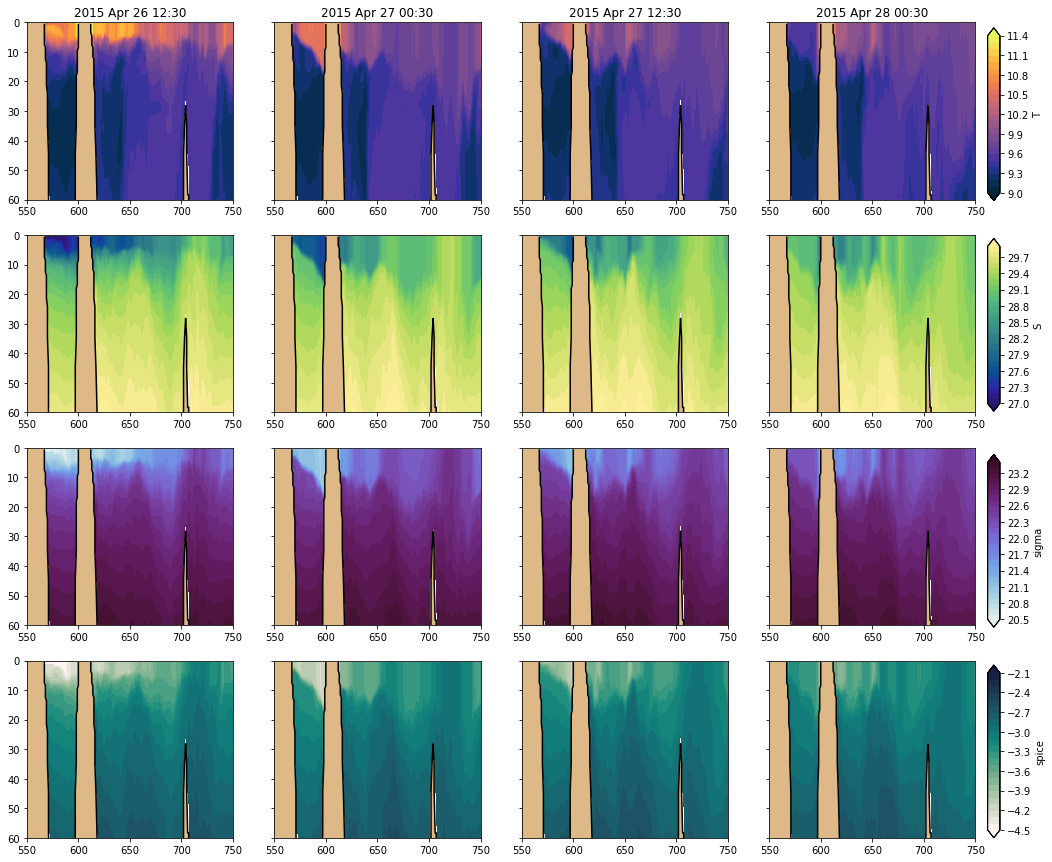

In [243]:
fig, axs = plt.subplots(4, 4, figsize=(17, 15))
xsec = 145
caxs = [fig.add_axes([0.91, y, 0.01, 0.16]) for y in [0.715, 0.52, 0.32, 0.125]]
keys = ['T', 'S', 'sigma', 'spice']
levels = ([9, 11.5, 0.1], [27, 30, 0.1], [20.5, 23.5, 0.1], [-4.5, -2, 0.1])
cmaps = [cm.thermal, cm.haline, cm.dense, cm.tempo]
for col, hour in zip(axs.T, hours):
    date = daterange[0] + timedelta(hours=hour)
    datestr = date.strftime('%Y%m%d')
    fn = os.path.join(path_NEMO, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_grid_T.nc')
    data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')
    for ax, cax, key, level, cmap in zip(col, caxs, keys, levels, cmaps):
        if key is 'T':
            z = np.ma.masked_where(mask_NEMO.tmask[0, ..., xsec] == 0, data['votemper'][..., xsec])
        elif key is 'S':
            z = np.ma.masked_where(mask_NEMO.tmask[0, ..., xsec] == 0, data['vosaline'][..., xsec])
        elif key is 'sigma':
            z = np.ma.masked_where(mask_NEMO.tmask[0, ..., xsec] == 0, gsw.rho(data['vosaline'][..., xsec], data['votemper'][..., xsec], data.deptht.values[:, np.newaxis])-1e3)
        elif key is 'spice':
            z = np.ma.masked_where(mask_NEMO.tmask[0, ..., xsec] == 0, gsw.spiciness0(data['vosaline'][..., xsec], data['votemper'][..., xsec]))
        c = ax.contourf(data.y, data.deptht, z, levels=np.arange(*level), cmap=cmap, extend='both')
        ax.contourf(data.y, data.deptht, mask_NEMO.tmask[0, ..., xsec], levels=[-0.01, 0.01], colors='Burlywood')
        ax.contour(data.y, data.deptht, mask_NEMO.tmask[0, ..., xsec], levels=[-0.01, 0.01], colors='k')
        ax.set_xlim([550, 750])
        ax.set_ylim([60, 0])
        if key is 'T':
            ax.set_title(data.time_counter.values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
        if hour > 60:
            ax.yaxis.set_ticklabels('')
        fig.colorbar(c, cax=cax, label=key)
plt.show()

Surface water is denser to the north of Hornby Island, so spatially uniform stratification in the control runs maybe preventing enhanced upwelling there relative to Qualicum Bay. Try new control runs with a longshore salinity gradient.